## Introduction

The direction planes take off and land depends on the direction of the wind. For safety and performance reasons aircrafts typically take off and land into the wind.  
At Heathrow there are two possible operations: easterly and westerly.
In this kernel I'll try to create some visualizations to better understand the statistics on operations for the period 2012-2018.  
The dataset contains the percentage of westerly and easterly operations for every day. There are no missing values.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns
import calendar
import warnings
warnings.filterwarnings('ignore')
import matplotlib.style as style
%matplotlib inline
style.available
style.use('ggplot')

init_notebook_mode(connected=True)
plt.rcParams['figure.figsize'] = [14, 6]

### Dataset sample

In [2]:
operations_df = pd.read_csv('../input/all.csv', parse_dates=True)
operations_df['date'] = operations_df['date'].astype('datetime64[ns]')
operations_df.sample(10)

,date,westerly,easterly
340,2012-12-06,1.000,0.000
1862,2017-02-05,0.421,0.579
107,2012-04-17,1.000,0.000
1223,2015-05-08,0.226,0.774
1829,2017-01-03,1.000,0.000
751,2014-01-21,0.877,0.123
186,2012-07-05,1.000,0.000
1825,2016-12-30,1.000,0.000
985,2014-09-12,0.000,1.000
52,2012-02-22,1.000,0.000


In [3]:
operations_df.isnull().sum()

date        0
westerly    0
easterly    0
dtype: int64

In [4]:
print(f">> Data Available since {operations_df.date.min()} up to {operations_df.date.max()}")

>> Data Available since 2012-01-01 00:00:00 up to 2018-12-31 00:00:00


In [5]:
print("Number days on westerly {}/{}".format(np.sum(operations_df['westerly'] >= 0.5), len(operations_df)))
print("Number days on easterly {}/{}".format(np.sum(operations_df['westerly'] < 0.5), len(operations_df)))

Number days on westerly 1825/2557
Number days on easterly 732/2557


In [6]:
print("Total percentage of westerly operations {}%".format(round(operations_df["westerly"].mean() * 100)))

Total percentage of westerly operations 71%


In [7]:
print("Total percentage of easterly operations {}%".format(round(operations_df["easterly"].mean() * 100)))

Total percentage of easterly operations 29%


### Considerations on dataset
The percentage of westerly operations considering everyday for 6 years is around 70%.  
Let's see how this changes taking in consideration each year independently.

In [8]:
operationMeanByYear = operations_df.groupby(operations_df.date.dt.year).mean()

### Split by year

In [9]:
trace1 = go.Bar(
    x=list(operationMeanByYear.index),
    y=list(operationMeanByYear['westerly'].values.round(3) * 100),
    name='Westerly',
    text=['%.2f' % elem for elem in list(operationMeanByYear['westerly'].values.round(3) * 100)],
    textposition = 'auto'
)
trace2 = go.Bar(
    x=list(operationMeanByYear.index),
    y=list(operationMeanByYear['easterly'].values.round(3) * 100),
    name='Easterly',
    text=['%.2f' % elem for elem in list(operationMeanByYear['easterly'].values.round(3) * 100)],
    textposition = 'auto'
)

data = [trace1, trace2]
layout = go.Layout(
    title='Percentage of operations per year (2012-2018)',
    barmode='stack',
    xaxis=dict(type='category')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

We can see that on different years the percentage of operations changes but stays around 70/30.  
The two extremes are 2017 with 80% of westerly operations and 2018 with 64% of westerlys.  
Let's see how the percentage of operations changes depending on the month for every year.

In [10]:
operations_df['month'] = operations_df.date.dt.month
operations_df['year'] = operations_df.date.dt.year
operations_df['day'] = operations_df.date.dt.day
operations_df['weekdayName'] = operations_df.date.dt.weekday_name
operations_df['weekday'] = operations_df.date.dt.weekday
operations_df['week'] = operations_df.date.dt.week
operations_df['weekend'] = operations_df.date.dt.weekday // 5 == 1

In [11]:
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
myCmap = colors.LinearSegmentedColormap.from_list("", ["red","yellow", "green"])

cdict = {'red':   ((0.0, 1.0, 1.0), 
                   (0.1, 1.0, 1.0),  # red 
                   (0.4, 1.0, 1.0),  # violet
                   (1.0, 0.0, 0.0)), # blue

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (0.1, 0.0, 0.0),  # red
                   (0.4, 1.0, 1.0),  # violet
                   (1.0, 1.0, 0.0))  # blue
          }

In [12]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return colors.LinearSegmentedColormap('CustomMap', cdict)


c = colors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('purple'), c('red'), 0.45, c('red'), c('yellow'), 0.65, c('yellow'), c('green'), 0.90, c('green')])

In [13]:
def plotHeathmap(df):
    plt.figure(figsize = (14, 10))

    ax = sns.heatmap(df, cmap = rvb, annot=True, fmt='.0%', vmin=0, vmax=1, linewidths=.5, annot_kws={"size": 18})
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .50,.75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 14)
    ax.tick_params(rotation = 0)
    plt.title('Westerley Operations', fontdict={'fontsize':18});

In [14]:
allMonthYear_df = pd.pivot_table(operations_df, values="westerly",index=["month"], columns=["year"], fill_value=None)
allMonthYear_df = allMonthYear_df.set_index([[calendar.month_abbr[i] for i in list(allMonthYear_df.index)]])

### Split by month

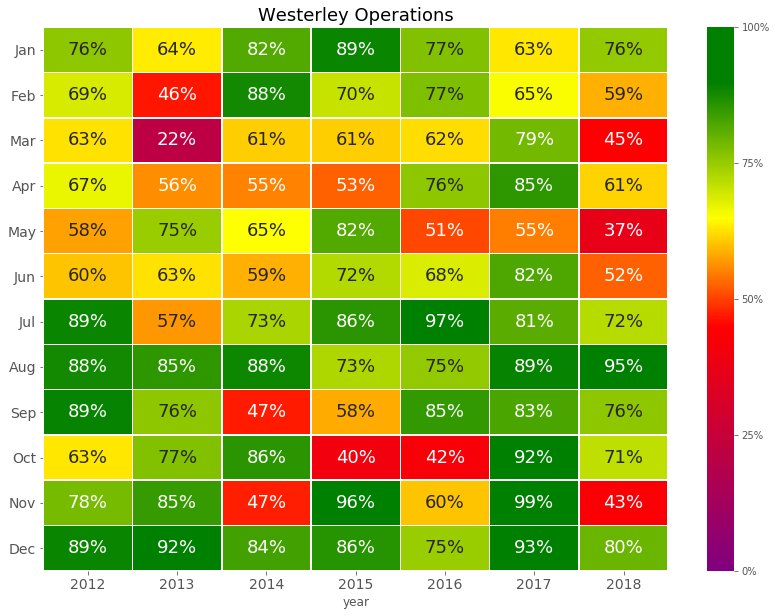

In [15]:
plotHeathmap(allMonthYear_df)

Although there are variations depening on the year we can see that in general springtime tends to have a higher percentage of easterly operations.  
The two extremes are March 2013 with only 22% of westerly operations and November 2017 with 99% of westerlys.  
It could be interesting to know how was the distribution over the day of the week, I don't expect to see anything significat but we can check if some particular year has been particularly affected on a specific day of the week.

In [16]:
allWeekDayYear_df = pd.pivot_table(operations_df, values="westerly",index=["weekday"], columns=["year"], fill_value=0.5)
allWeekDayYear_df = allWeekDayYear_df.set_index([[calendar.day_name[i] for i in list(allWeekDayYear_df.index)]])

### Split by weekday

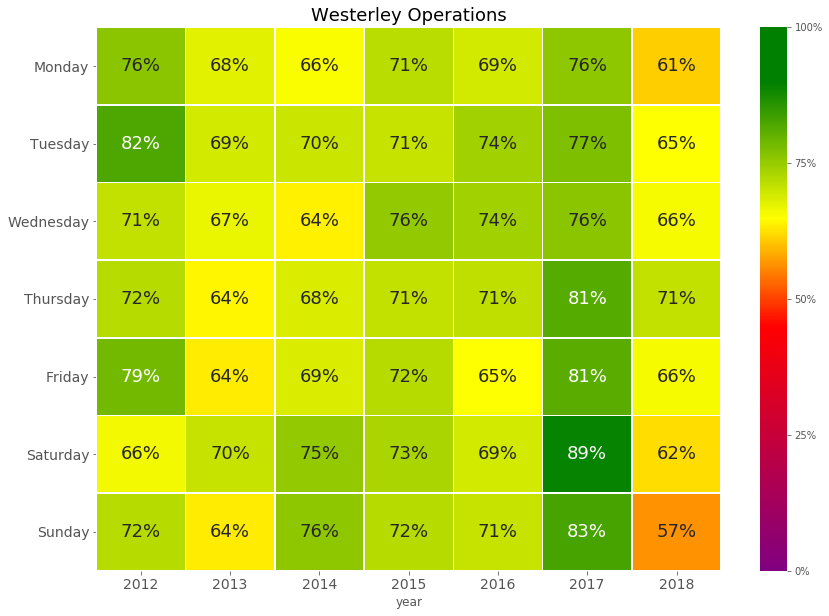

In [17]:
plotHeathmap(allWeekDayYear_df)

Sundays of 2018 hve been particulary affected by lower than usual westerly operations while Saturdays in 2017 had the highest rate of westerlys.  
We can now check percentage of operations during weekends.

### Split by weekends

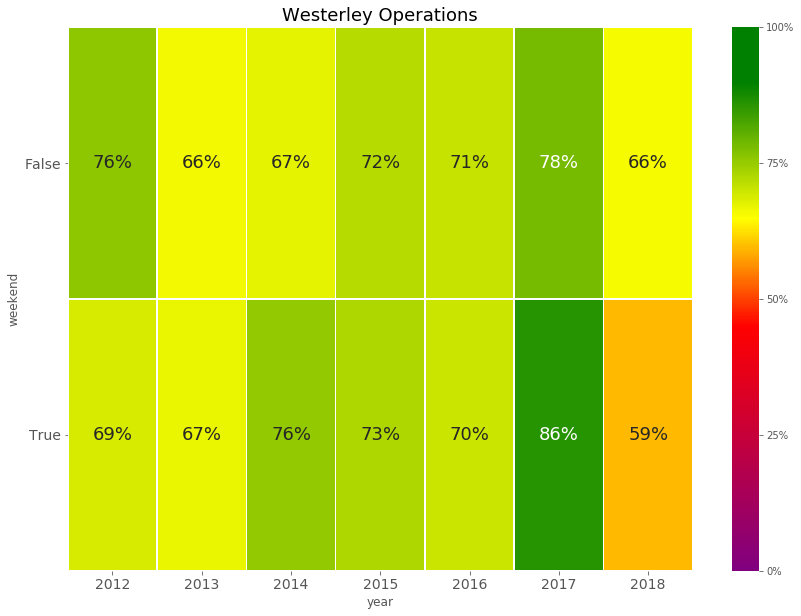

In [18]:
allWeekendYear_df = pd.pivot_table(operations_df, values="westerly",index=["weekend"], columns=["year"], fill_value=0.5)
plotHeathmap(allWeekendYear_df)

Similar to the split by weekday we can see how weekends in 2018 have seen a lower than usual percentage of westerly operations. 

### Moving average

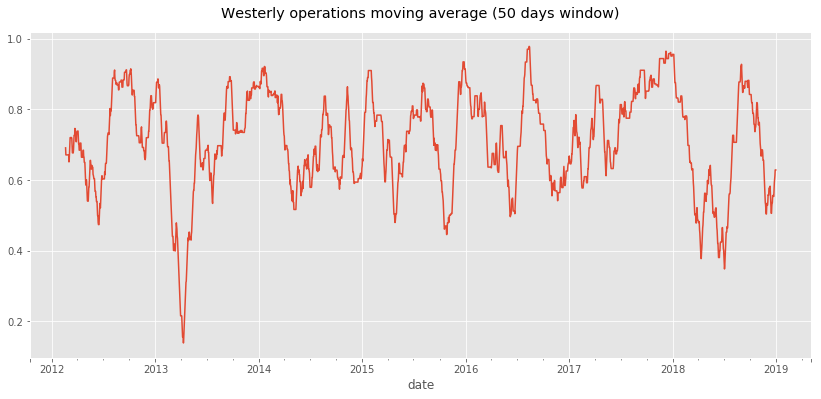

In [19]:
justW_df = operations_df.set_index('date')['westerly']
plt.figure(figsize = (14, 6))
plt.title('Westerly operations moving average (50 days window)', pad=14)
_ = justW_df.rolling(50).mean().plot()

We can see some periods with lower than usual westerly operations percentage, there was a long period in early 2013 with low values (meaning more frequent easterly operations).  

In [20]:
def plotHeatmapYear(year):
    plt.figure(figsize = (16, 10))
    allByYear_df = operations_df.loc[operations_df['year'] == year]
    allByYear_df = pd.pivot_table(allByYear_df, values="westerly",index=["month"], columns=["day"], fill_value=None)
    allByYear_df = allByYear_df.set_index([[calendar.month_abbr[i] for i in list(allByYear_df.index)]])
    ax = sns.heatmap(allByYear_df, cmap = 'RdYlGn', annot=False, fmt='.0%', vmin=0, vmax=1, linewidths=.1,
                     annot_kws={"size": 8}, square=True, cbar_kws={"shrink": .48, 'label': 'Westerly percentage'})
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 12)
    ax.tick_params(rotation = 0)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .50,.75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    plt.title(f'Operations {year}', fontdict={'fontsize':18}, pad=14);

### Daily westerly operations percentages
It can be interesting to see the percentage of westerly operations for each day, for that we can create a heatmap for each year.

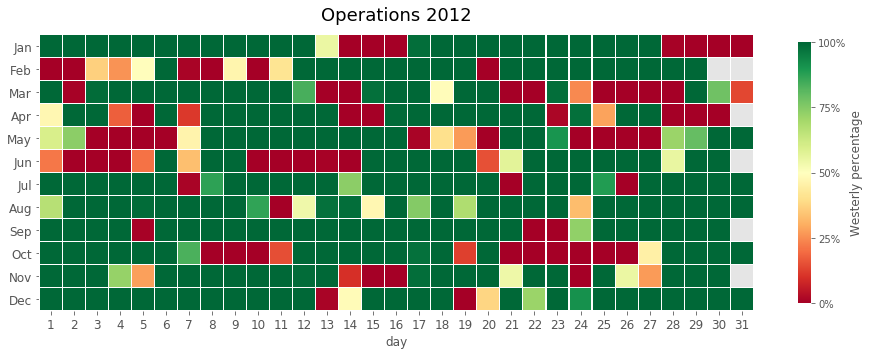

In [21]:
plotHeatmapYear(2012)

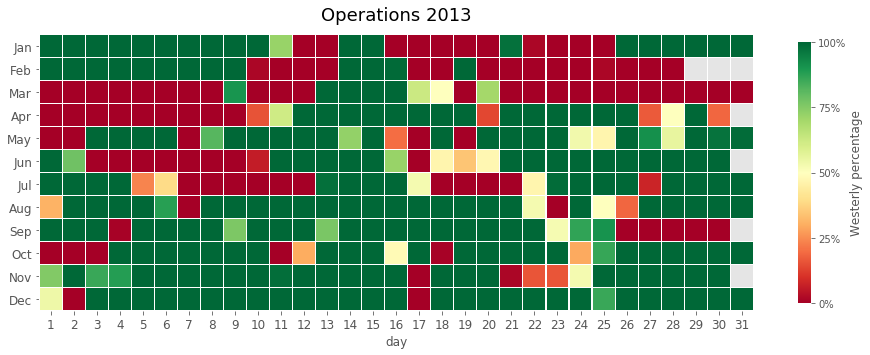

In [22]:
plotHeatmapYear(2013)

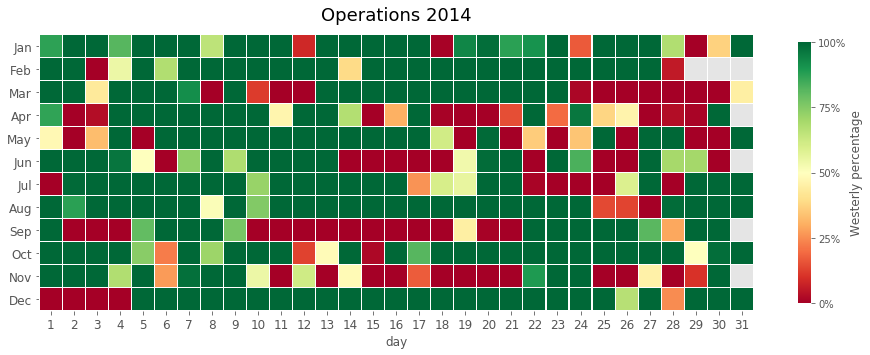

In [23]:
plotHeatmapYear(2014)

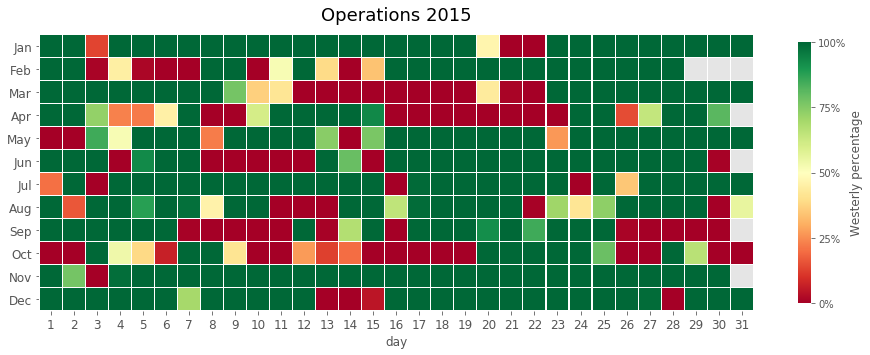

In [24]:
plotHeatmapYear(2015)

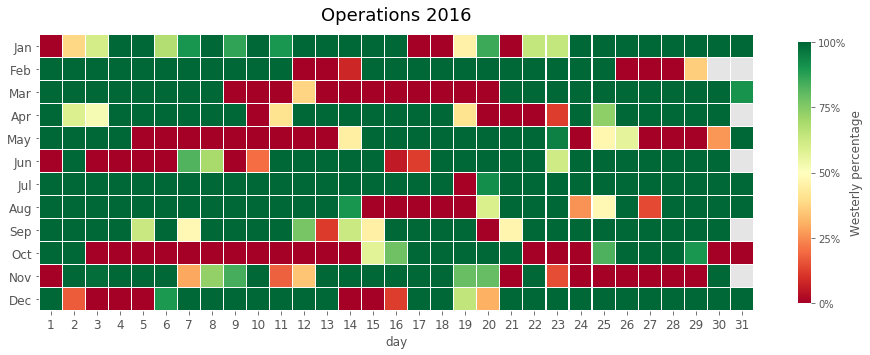

In [25]:
plotHeatmapYear(2016)

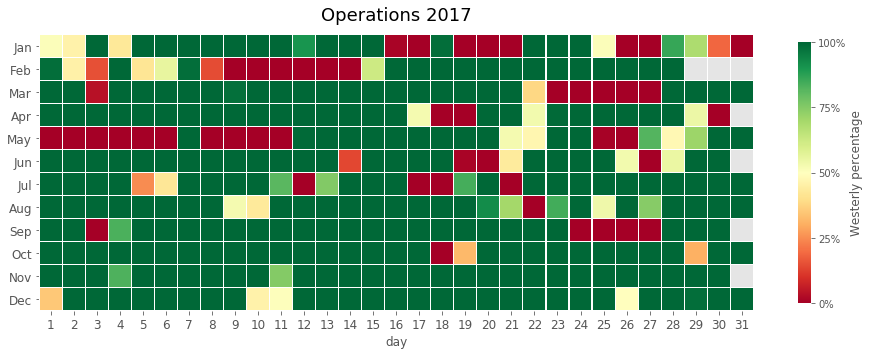

In [26]:
plotHeatmapYear(2017)

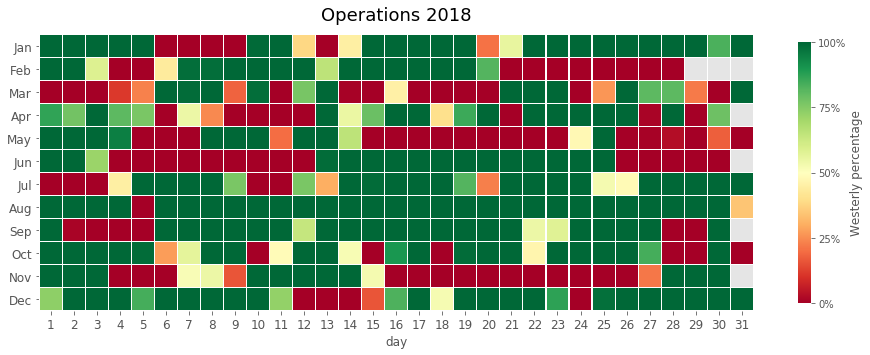

In [27]:
plotHeatmapYear(2018)

### Westerly operations averages percentages (2012-2018)
It can be interesting to see over a period of 6 years the averages on operations percentanges per day.
With this we can see if there are particular days where a certain kind of operations are more common.

In [28]:
df = operations_df.groupby([operations_df.date.dt.month, operations_df.date.dt.day])['westerly'].mean()
allDaysMean = df.unstack()
allDaysMean.index
allDaysMean = allDaysMean.set_index([[calendar.month_abbr[i] for i in list(allDaysMean.index)]])

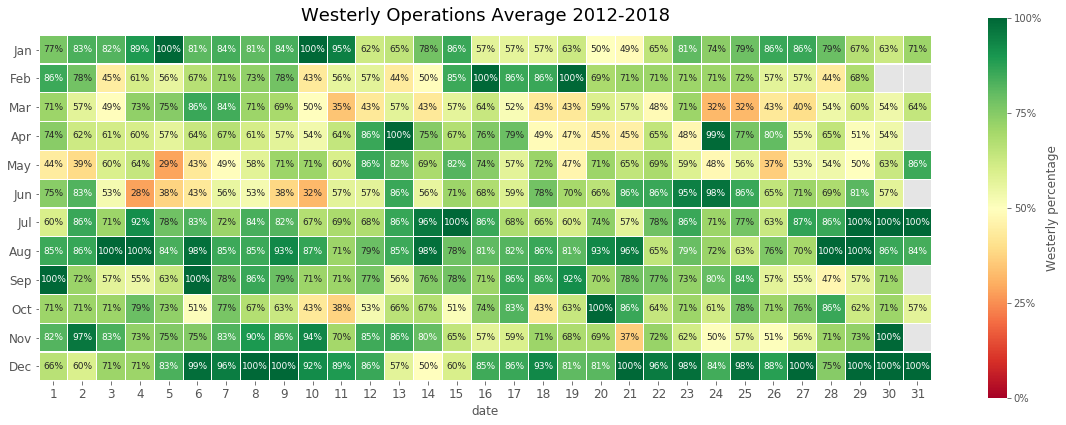

In [29]:
plt.figure(figsize = (20, 14))
ax = sns.heatmap(allDaysMean, cmap = 'RdYlGn', annot=True, fmt='.0%', vmin=0, vmax=1, linewidths=.1,
                 annot_kws={"size": 9}, square=True, cbar_kws={"shrink": .5, 'label': 'Westerly percentage'})
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 12)
ax.tick_params(rotation = 0)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .50,.75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
_ = plt.title(f'Westerly Operations Average 2012-2018', fontdict={'fontsize':18}, pad=14)

It seems that From March to June there's an higher rate of easterly operations than the rest of the year.

### Operations distribution (2012-2018)

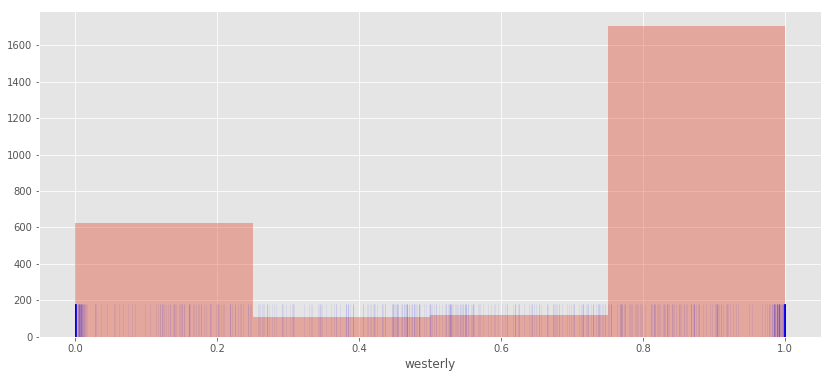

In [30]:
plt.figure(figsize = (14, 6))
_ = sns.distplot(operations_df['westerly'], kde=False, rug=True, bins = 4, rug_kws={"color": "b", "alpha":0.06, "linewidth": 1, "height":0.1 }
)

Most of the days are either entirely on easterlyes or westerlys.

### Operations distribution per year

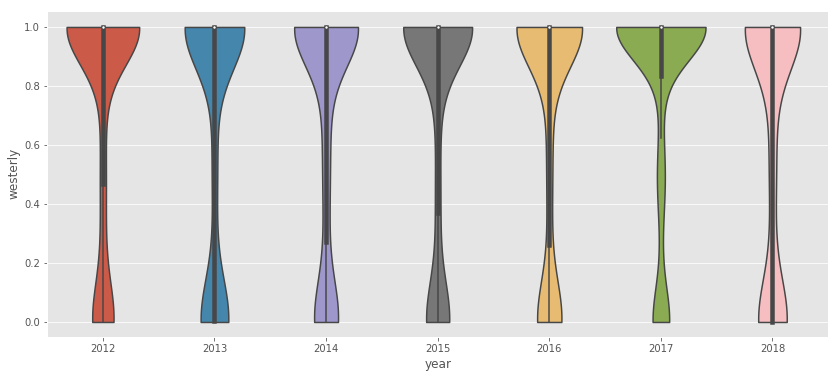

In [31]:
plt.figure(figsize = (14, 6))
_ = sns.violinplot(x="year", y="westerly",cut=0, data=operations_df)

In [32]:
operations_df['westTolerance'] = operations_df['westerly'].apply(lambda x: round(x))
daysCountWDf = operations_df.groupby('year')['westTolerance'].sum()

In [33]:
daysCountWDf = daysCountWDf.reset_index()
operations_df['eastTolerance'] = operations_df['easterly'].apply(lambda x: round(x))
daysCountEDf = operations_df.groupby('year')['eastTolerance'].sum()
daysCountEDf = daysCountEDf.reset_index()
daysCount = daysCountWDf.merge(daysCountEDf)
daysCount.columns = ['year', 'Westerly', 'Easterly']

### Number of days per year on a specific operation (>50%)

In [34]:
daysCount

,year,Westerly,Easterly
0,2012,269,97
1,2013,244,119
2,2014,255,109
3,2015,263,102
4,2016,258,108
5,2017,296,69
6,2018,237,128


In [35]:
daysCount = pd.melt(daysCount, id_vars=['year'], value_vars=['Westerly', 'Easterly'],
...         var_name='operations', value_name='days')

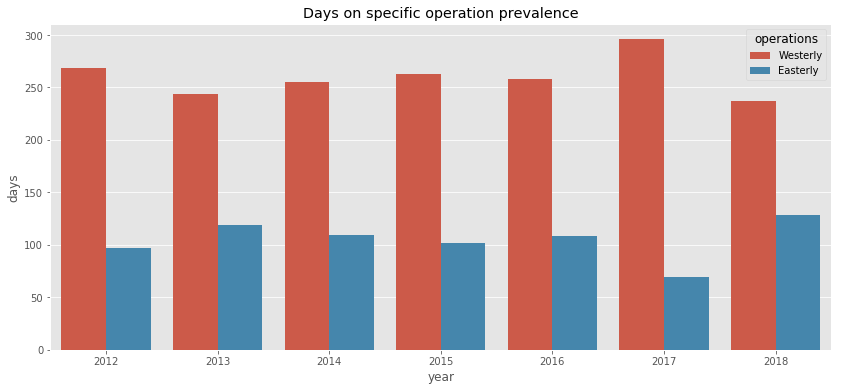

In [36]:
plt.figure(figsize = (14, 6))
ax = sns.barplot(x="year", y='days', hue="operations", data=daysCount.sort_values(by='year'))
_ = ax.set_title("Days on specific operation prevalence")

2017 was the year with less days on Easterly (only 69), while 2018 was the one with most days on easterly (128).

In [37]:
operations_df['value_grp'] = (operations_df['westerly'].diff(1) != 0).astype('int').cumsum()
groupedValue = operations_df.groupby('value_grp')
consecutive_df = pd.DataFrame({'BeginDate' : groupedValue.date.first(), 
              'EndDate' : groupedValue.date.last(),
              'Consecutive' : groupedValue.size(),
              'ops': groupedValue.westerly.mean() }).reset_index(drop=True)
consecutive_df['ops'].replace({0: 'Easterly', 1: 'Westerly'}, inplace=True)
consecutive_df = consecutive_df[(consecutive_df.ops == 'Westerly') | (consecutive_df.ops == 'Easterly')]
consecutive_df.sort_values(by='Consecutive', ascending=False).head(30)

,BeginDate,EndDate,Consecutive,ops
615,2015-11-05,2015-12-06,32,Westerly
981,2018-08-06,2018-08-30,25,Westerly
690,2016-06-24,2016-07-18,25,Westerly
693,2016-07-21,2016-08-13,24,Westerly
479,2014-12-05,2014-12-25,21,Westerly
501,2015-02-16,2015-03-08,21,Westerly
195,2013-03-21,2013-04-09,20,Easterly
791,2017-03-28,2017-04-16,20,Westerly
852,2017-09-29,2017-10-17,19,Westerly
641,2016-01-24,2016-02-11,19,Westerly


### Longest period with same operations


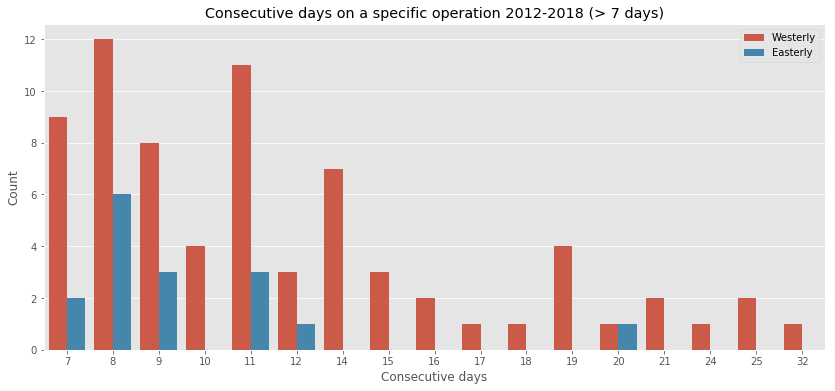

In [38]:
plt.figure(figsize = (14, 6))
ax = sns.countplot(x="Consecutive", hue="ops", data=consecutive_df.query('Consecutive >= 7'))
ax.set_title("Consecutive days on a specific operation 2012-2018 (> 7 days)")
ax.set(xlabel='Consecutive days', ylabel='Count')
_ = plt.legend(loc='upper right')

The longest period with westerly operations was 32 days while the longest with easterly was 20 days.  
Both happened just once in 6 years.